# Out-of-core Analysis

With the ever-growing size of datasets, being able to operate on larger-than-memory data is every important.  Both [`scanpy`](https://scanpy.readthedocs.io/en/stable/) (CPU) and [`rapids_singlecell`](https://rapids-singlecell.readthedocs.io/en/latest/) (GPU) support full out-of-core, parallelizable analysis steps.  The [`ad.experimental.read_elem_as_dask`](https://anndata.readthedocs.io/en/latest/generated/anndata.experimental.read_elem_as_dask.html) enables users to lazily load numeric matrix elements of the `AnnData`, such as `X` or `obsm["X_pca"]`.   In this notebook, we'll generate a PCA on an 100,000,000 cells from various cell lines with different treatments before visualizing a subset of the data.  Downstream tasks could include anything from deep-learning to a linear classifier.

For individual tutorials, see [here](https://rapids-singlecell.readthedocs.io/en/latest/notebooks/multi_gpu_show.html) for rapids-singlecell and [here](https://scanpy.readthedocs.io/en/stable/tutorials/experimental/dask.html) for scanpy

In [1]:
from pathlib import Path

import numpy as np
import dask.distributed as dd
import scanpy as sc
import anndata as ad
import h5py
import dask

from collections import Counter
import pandas as pd
from tqdm import tqdm
import dask
import time
from dask.distributed import Client, LocalCluster

import dask

sc.logging.print_header()

/home/icb/weixu.wang/miniconda3/envs/rapids_singlecell/lib/python3.12/site-packages/session_info2/__init__.py:124: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  and (v := getattr(pkg, "__version__", None))
/tmp/ipykernel_632503/582836007.py:19: RuntimeWarning: Failed to import dependencies for application/vnd.jupyter.widget-view+json representation. (ModuleNotFoundError: No module named 'ipywidgets')
  sc.logging.print_header()


Package,Version
numpy,1.26.4
dask,2024.11.2
scanpy,1.11.0rc2
anndata,0.11.0rc3
h5py,3.12.1
pandas,2.2.3
tqdm,4.67.1
distributed,2024.11.2
Component,Info
Python,"3.12.8 | packaged by conda-forge | (main, Dec 5 2024, 14:24:40) [GCC 13.3.0]"


## Technical Notes

To turn on one or the other of GPU or CPU, use the flag below. If you are using a GPU, configure the `gpus` flag accordingly to the number of GPUs you have available.  Similarly, for the CPU implementation, you can configure the number of workers.  We ran this notebook using CPU with a slurm configuration like `srun ... -c 32 --mem=300gb`, using 16 dask workers and the below sparse chunks size while we were only able to get one GPU, although the beauty of `dask` is that one is enough to complete the analysis thanks to the out-of-core capabilities.  You can of course use fewer CPU cores and this notebook will still be runnable, such is the beauty of truly lazy, chunked computation.  Nothing is loaded into memory until it is needed, and only the amount needed to perform the local computation on a chunk of the data.

The interplay between memory and workers is delicate - too many workers and not enough memory will cause your calculation to crash, so often it is good to have a few fewer workers than you think would be best.  For example, because a single GPU has somewhere in the range of 32GB, that is more than the individual 16 workers can have who split the 300GB, thereby allowing for a larger chunk size.  Furthermore with [rapids-memory-management](https://github.com/rapidsai/rmm), memory concerns are not so overriding on the GPU.

**Caution**: Out-of-core support is still quite new in both packages, so we are learning more and more daily about performance optimizations. The information here about performance thus represents our best attempt to provide advice on performance. On only one GPU, preprocessing can be quite lengthy, and therefore it is advisable to use rapids only with more than one GPU (be sure to update the `gpus` variable accordingly to reflect this - it should be something like `'0,1,2,3'`, for example, for four GPUs).  Otherwise, we have observed that the single-GPU PCA is faster than the multi-core PCA (~12.5 min vs. ~18 min), but the time needed to bring the data back to the CPU from the GPU for writing causes the two to be comparable i.e., PCA + writing the results has the same time between one GPU and multi-core CPU with the above specs.

In [2]:
use_gpu = False

In [3]:
if use_gpu:
    import rapids_singlecell as rsc
    SPARSE_CHUNK_SIZE = 1_000_000
    from dask_cuda import LocalCUDACluster

    import rmm
    import cupy as cp
    from cupyx.scipy import spx

    from rmm.allocators.cupy import rmm_cupy_allocator

    def set_mem():
        rmm.reinitialize(managed_memory=True)
        cp.cuda.set_allocator(rmm_cupy_allocator)
    gpus = "0" # comma separated like "0,1,2" for 3 gpus
    cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=gpus)
    dask.array.register_chunk_type(spx.csr_matrix)
else:

    SPARSE_CHUNK_SIZE = 100_000
    cluster = LocalCluster(n_workers=16)

In [4]:
client = Client(cluster)
if use_gpu:
    client.run(set_mem)
    mod = rsc
else:
    mod = sc

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 240.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8477,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 240.00 GiB
Comm: tcp://127.0.0.1:8483,Total threads: 1
Dashboard: http://127.0.0.1:8265/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:8285,


## Preprocessing

First, let's do some standard preprocessing on the datasets.  Note that we use `ad.experimental.read_elem_as_dask` to load the big data, the cell x gene matrix, lazily.  The preprocessing is then done lazily i.e., normalization, log1p, and highly variable gene selection.  Individually, we'll do this and then merge all the datasets into one large dataset to be used in the next step. We'll finally merge the data into one large `AnnData` for the PCA.  Writing this out and then reading it back in is faster than rechunking a virtually concatenated i.e., `anndata.concat` dataset (`dask` requires uniform chunks, which would not be possible without rechunking).

In [ ]:
%%time
adatas = []
all_highly_variable_genes = []
for i in tqdm(range(14)):
    id = str(i + 1)
    PATH = f"/lustre/groups/ml01/workspace/weixu.wang/100m/plate{id}_filtered.h5ad"

    with h5py.File(PATH, "r") as f:
        adata = ad.AnnData(
            obs=ad.io.read_elem(f["obs"]),
            var=ad.io.read_elem(f["var"]),
        )
        adata.X = ad.experimental.read_elem_as_dask(
            f["X"], chunks=(SPARSE_CHUNK_SIZE, adata.shape[1])
        )

    if use_gpu:
        rsc.get.anndata_to_GPU(adata)

    # 100m filtering
    pass_filter_mask = adata.obs["pass_filter"] == "full"
    adata = adata[pass_filter_mask, :].copy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)

    highly_variable_genes = set(adata.var_names[adata.var["highly_variable"]])
    all_highly_variable_genes.append(highly_variable_genes)
    adatas.append(adata)

## select the genes appears more than two plates
gene_counts = Counter(gene for genes in all_highly_variable_genes for gene in genes)
selected_genes = {gene for gene, count in gene_counts.items() if count > 2}

for i in tqdm(range(14)):
    id = str(i + 1)

    common_genes = list(set(adata.var_names) & selected_genes)
    adata = adatas[i][:, common_genes].copy()

    output_path = f"/lustre/groups/ml01/workspace/ilan.gold/100m/plate{id}_filtered_preprocessed_{'gpu' if use_gpu else 'cpu'}.h5ad"
    adata.write_h5ad(output_path)

## Merge all data into giant file

We'll now merge the data into one large file for the PCA.  This is faster than rechunking a virtually concatenated i.e., `anndata.concat` dataset (`dask` requires uniform chunks, which would not be possible without rechunking).  Furthermore, rechunking can cause a memory blow-up.

In [ ]:
%%time
data_dict = {}
for i in range(14):
    data_dict.update({f"plate_{i+1}": f"/lustre/groups/ml01/workspace/ilan.gold/100m/plate{i+1}_filtered_preprocessed_{'gpu' if use_gpu else 'cpu'}.h5ad"})
ad.experimental.concat_on_disk(
    data_dict,
    f'/lustre/groups/ml01/workspace/ilan.gold/100m/plate_merged_{"gpu" if use_gpu else "cpu"}.h5ad',
    label='plate',
)

## Calculate cell embeddings

To do this we will use PCA.  Both `scanpy` and `rapids_singlecell` provide out-of-core implementations of PCA on sparse datasets.

In [8]:
%%time
with h5py.File(f"/lustre/groups/ml01/workspace/ilan.gold/100m/plate_merged_{'gpu' if use_gpu else 'cpu'}.h5ad", "r") as f:
    adata = ad.AnnData(
        obs=ad.io.read_elem(f["obs"]),
        var=ad.io.read_elem(f["var"]),
    )
    adata.X = ad.experimental.read_elem_as_dask(
        f["X"], chunks=(SPARSE_CHUNK_SIZE, adata.shape[1])
    )

CPU times: user 2min 13s, sys: 59.2 s, total: 3min 12s
Wall time: 3min 40s


In [9]:
adata

AnnData object with n_obs × n_vars = 95624334 × 2304
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'plate'
    obsm: 'X_pca'

In [13]:
%%time
if use_gpu:
    rsc.get.anndata_to_GPU(adata)

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 29.3 μs


In [14]:
%%time
mod.pp.pca(adata, n_comps=300, mask_var=None)
if use_gpu:
    adata.obsm["X_pca"] = adata.obsm["X_pca"].map_blocks(
        lambda x: x.get(), meta=np.array([]), dtype=adata.obsm["X_pca"].dtype
    ) # bring back to CPU

CPU times: user 4min, sys: 26.1 s, total: 4min 26s
Wall time: 17min 11s


In [15]:
%%time
adata.obsm["X_pca"].to_zarr(f"/lustre/groups/ml01/workspace/ilan.gold/100m/plate_merged_pca_{'gpu' if use_gpu else 'cpu'}.zarr")

CPU times: user 2min 48s, sys: 19.3 s, total: 3min 7s
Wall time: 15min 14s


Now the data can be read back in with `dask` if needed and put into the `anndata` object.  A slight more complex way to write the data, but perhaps more `anndata`-ic would have been to use `write_elem`: https://anndata.readthedocs.io/en/latest/generated/anndata.io.write_elem.html

In [10]:
%%time
adata.obsm["X_pca"] = dask.array.from_zarr(f"/lustre/groups/ml01/workspace/ilan.gold/100m/plate_merged_pca_{'gpu' if use_gpu else 'cpu'}.zarr")

CPU times: user 196 ms, sys: 70.1 ms, total: 266 ms
Wall time: 1.23 s


## Visualization

Briefly, we visualize a subset of the results to avoid meaningless overplotting.  However, the full PCA results are still available on disk and are ready for use downstream, whether in deep-learning applications or for simple linear classifiers.

In [10]:
%%time
subset_adata = adata[np.random.randint(0, adata.shape[0], (1_000_000,))]
subset_adata

CPU times: user 1.56 s, sys: 676 ms, total: 2.24 s
Wall time: 3.35 s


View of AnnData object with n_obs × n_vars = 1000000 × 2304
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'bc1_well', 'bc2_well', 'bc3_well', 'id', 'drugname_drugconc', 'drug', 'INT_ID', 'NUM.SNPS', 'NUM.READS', 'demuxlet_call', 'BEST.GUESS', 'BEST.LLK', 'NEXT.GUESS', 'NEXT.LLK', 'DIFF.LLK.BEST.NEXT', 'BEST.POSTERIOR', 'SNG.POSTERIOR', 'cell_line', 'SNG.BEST.LLK', 'SNG.NEXT.GUESS', 'SNG.NEXT.LLK', 'SNG.ONLY.POSTERIOR', 'DBL.BEST.GUESS', 'DBL.BEST.LLK', 'DIFF.LLK.SNG.DBL', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'cell_line_orig', 'pass_filter', 'cell_name', 'plate'
    obsm: 'X_pca'

In [12]:
%%time
if use_gpu:
    subset_adata.obsm["X_pca"] = subset_adata.obsm["X_pca"].map_blocks(
        spx.csr_matrix, spx.csr_matrix(np.array([])), dtype=subset_adata.obsm["X_pca"].dtype
    ) # bring back to GPU
else:
    subset_adata.obsm["X_pca"] = subset_adata.obsm["X_pca"].compute() 

/ictstr01/home/icb/ilan.gold/test_ken/venv/lib64/python3.12/site-packages/anndata/_core/index.py:173: PerformanceWarning: Slicing with an out-of-order index is generating 1044 times more chunks
  return a[subset_idx]
/ictstr01/home/icb/ilan.gold/test_ken/venv/lib64/python3.12/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 49.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
<timed exec>:1: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/ictstr01/home/icb/ilan.gold/test_ken/venv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


CPU times: user 9min 20s, sys: 35.3 s, total: 9min 56s
Wall time: 10min 35s


/ictstr01/home/icb/ilan.gold/test_ken/venv/lib64/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [13]:
%%time
mod.pp.neighbors(subset_adata)

/ictstr01/home/icb/ilan.gold/test_ken/venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 10min 5s, sys: 24.9 s, total: 10min 30s
Wall time: 9min 40s


In [14]:
%%time
mod.tl.umap(subset_adata)
if use_gpu:
    subset_adata.obsm["X_umap"] = subset_adata.obsm["X_umap"].get()

CPU times: user 2h 35min 37s, sys: 25.3 s, total: 2h 36min 3s
Wall time: 23min 32s


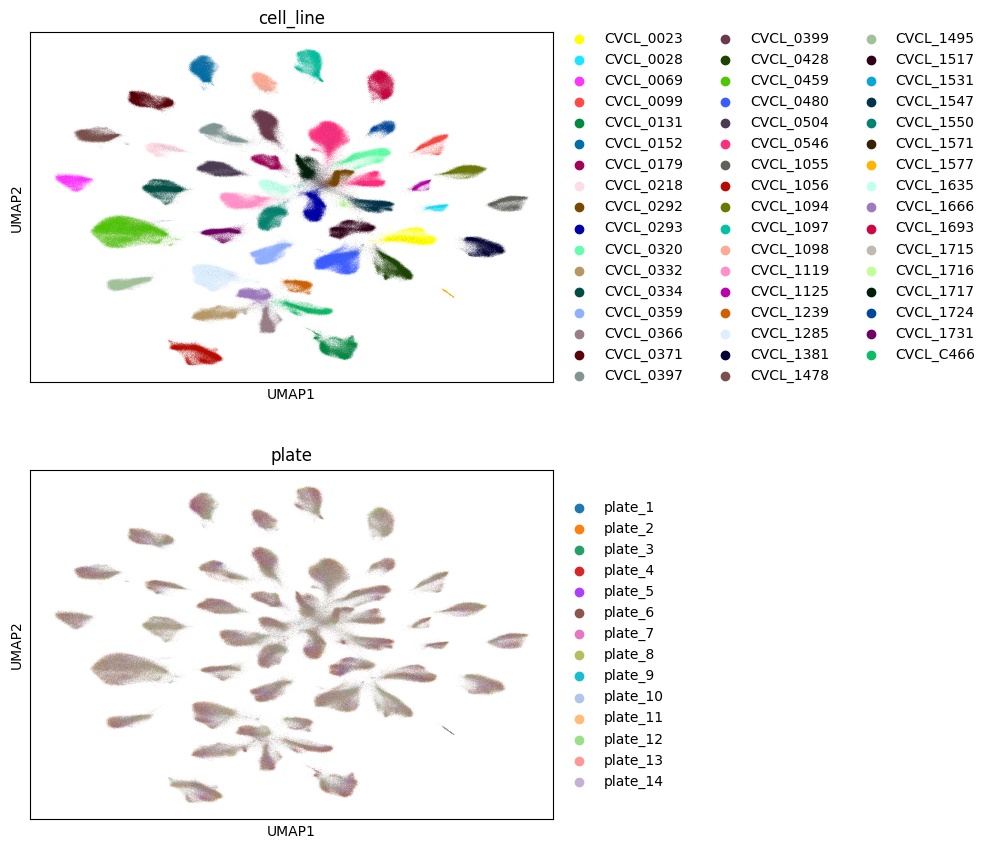

CPU times: user 11 s, sys: 514 ms, total: 11.5 s
Wall time: 14.7 s


In [21]:
%%time
sc.pl.umap(
    subset_adata,
    color=["cell_line", "plate"],
    ncols=1
)